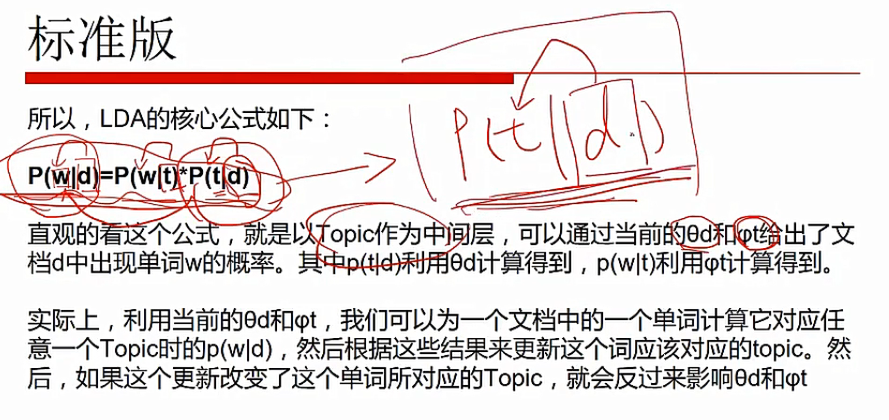

In [1]:
import numpy as np
import pandas as pd
import re

In [3]:
df = pd.read_csv("HillaryEmails.csv")
# 原邮件数据中有很多Nan的值，直接扔了。
df = df[['Id','ExtractedBodyText']].dropna()

In [5]:
def clean_email_text(text):
    text = text.replace('\n'," ") #新行，我们是不需要的
    text = re.sub(r"-", " ", text) #把 "-" 的两个单词，分开。（比如：july-edu ==> july edu）
    text = re.sub(r"\d+/\d+/\d+", "", text) #日期，对主体模型没什么意义
    text = re.sub(r"[0-2]?[0-9]:[0-6][0-9]", "", text) #时间，没意义
    text = re.sub(r"[\w]+@[\.\w]+", "", text) #邮件地址，没意义
    text = re.sub(r"/[a-zA-Z]*[:\//\]*[A-Za-z0-9\-_]+\.+[A-Za-z0-9\.\/%&=\?\-_]+/i", "", text) #网址，没意义
    pure_text = ''
    # 以防还有其他特殊字符（数字）等等，我们直接把他们loop一遍，过滤掉
    for letter in text:
        # 只留下字母和空格
        if letter.isalpha() or letter==' ':
            pure_text += letter
    # 再把那些去除特殊字符后落单的单词，直接排除。
    # 我们就只剩下有意义的单词了。
    text = ' '.join(word for word in pure_text.split() if len(word)>1)
    return text

In [6]:
docs = df['ExtractedBodyText']
docs = docs.apply(lambda s: clean_email_text(s))  

In [60]:
type(docs)

pandas.core.series.Series

In [9]:
docs.head(1).values

array(['Thursday March PM Latest How Syria is aiding Qaddafi and more Sid hrc memo syria aiding libya docx hrc memo syria aiding libya docx March For Hillary'],
      dtype=object)

In [10]:
# 直接把所有的邮件内容拿出来
doclist = docs.values


## LDA模型构建：

好，我们用Gensim来做一次模型构建

首先，我们得把我们刚刚整出来的一大波文本数据

[[一条邮件字符串]，[另一条邮件字符串], ...]

转化成Gensim认可的语料库形式：

[[一，条，邮件，在，这里],[第，二，条，邮件，在，这里],[今天，天气，肿么，样],...]

引入库：


In [11]:
#corpora语料，models模型，similarities相似度
from gensim import corpora, models, similarities
import gensim

C:\Anaconda3\envs\py2\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
# 停止词列表：
stoplist = ['very', 'ourselves', 'am', 'doesn', 'through', 'me', 'against', 'up', 'just', 'her', 'ours', 
            'couldn', 'because', 'is', 'isn', 'it', 'only', 'in', 'such', 'too', 'mustn', 'under', 'their', 
            'if', 'to', 'my', 'himself', 'after', 'why', 'while', 'can', 'each', 'itself', 'his', 'all', 'once', 
            'herself', 'more', 'our', 'they', 'hasn', 'on', 'ma', 'them', 'its', 'where', 'did', 'll', 'you', 
            'didn', 'nor', 'as', 'now', 'before', 'those', 'yours', 'from', 'who', 'was', 'm', 'been', 'will', 
            'into', 'same', 'how', 'some', 'of', 'out', 'with', 's', 'being', 't', 'mightn', 'she', 'again', 'be', 
            'by', 'shan', 'have', 'yourselves', 'needn', 'and', 'are', 'o', 'these', 'further', 'most', 'yourself', 
            'having', 'aren', 'here', 'he', 'were', 'but', 'this', 'myself', 'own', 'we', 'so', 'i', 'does', 'both', 
            'when', 'between', 'd', 'had', 'the', 'y', 'has', 'down', 'off', 'than', 'haven', 'whom', 'wouldn', 
            'should', 've', 'over', 'themselves', 'few', 'then', 'hadn', 'what', 'until', 'won', 'no', 'about', 
            'any', 'that', 'for', 'shouldn', 'don', 'do', 'there', 'doing', 'an', 'or', 'ain', 'hers', 'wasn', 
            'weren', 'above', 'a', 'at', 'your', 'theirs', 'below', 'other', 'not', 're', 'him', 'during', 'which']

In [29]:
texts = [[word for word in doc.lower().split() if word not in stoplist] for doc in doclist]

In [32]:
texts[1]

['thx']


## 建立语料库

用词袋的方法，把每个单词用一个数字index指代，并把我们的原文本变成一条长长的数组：

labelincode


In [38]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [39]:
corpus[13]

[(51, 1), (505, 1), (506, 1), (507, 1), (508, 1)]



这个列表告诉我们，第14（从0开始是第一）个邮件中，一共6个有意义的单词（经过我们的文本预处理，并去除了停止词后）

其中，36号单词出现1次，505号单词出现1次，以此类推。。。

接着，我们终于可以建立模型了：


In [40]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20)

In [41]:
# 第10号分类，其中最常出现的前5个单词是
lda.print_topic(10, topn=5)

u'0.021*"pm" + 0.018*"state" + 0.011*"treaty" + 0.009*"department" + 0.007*"us"'

In [42]:
# 把所有的主题打印出来
lda.print_topics(num_topics=20, num_words=5)

[(0,
  u'0.006*"labour" + 0.006*"would" + 0.006*"percent" + 0.005*"election" + 0.005*"vote"'),
 (1,
  u'0.012*"see" + 0.009*"like" + 0.008*"bloomberg" + 0.006*"said" + 0.006*"palestinian"'),
 (2,
  u'0.017*"qddr" + 0.005*"rains" + 0.005*"traveling" + 0.005*"emailed" + 0.005*"email"'),
 (3,
  u'0.005*"would" + 0.005*"iranian" + 0.005*"american" + 0.004*"us" + 0.004*"said"'),
 (4,
  u'0.020*"thx" + 0.009*"negotiating" + 0.006*"call" + 0.006*"avoid" + 0.005*"company"'),
 (5,
  u'0.026*"state" + 0.013*"secretary" + 0.009*"assistant" + 0.008*"department" + 0.007*"pm"'),
 (6,
  u'0.013*"us" + 0.008*"nuclear" + 0.007*"sent" + 0.007*"via" + 0.005*"state"'),
 (7,
  u'0.007*"tomorrow" + 0.005*"time" + 0.005*"mcchrystal" + 0.005*"week" + 0.004*"received"'),
 (8,
  u'0.013*"haitian" + 0.009*"un" + 0.007*"haiti" + 0.006*"people" + 0.006*"port"'),
 (9,
  u'0.031*"ok" + 0.007*"part" + 0.006*"email" + 0.006*"gelb" + 0.006*"release"'),
 (10,
  u'0.021*"pm" + 0.018*"state" + 0.011*"treaty" + 0.009*"depa

接下来：

通过

lda.get_document_topics(bow)

或者

lda.get_term_topics(word_id)

两个方法，我们可以把新鲜的文本/单词，分类成20个主题中的一个。

但是注意，我们这里的文本和单词，都必须得经过同样步骤的文本预处理+词袋化，也就是说，变成数字表示每个单词的形式。

In [63]:
text=['To all the little girls watching...never doubt that you are valuable and powerful & deserving of every chance & opportunity in the world.']

In [64]:
text[0]

'To all the little girls watching...never doubt that you are valuable and powerful & deserving of every chance & opportunity in the world.'

In [80]:
text_docs = [clean_email_text(text[0])]

In [106]:
text_docs

['To all the little girls watchingnever doubt that you are valuable and powerful deserving of every chance opportunity in the world']

In [83]:
texts = [[word for word in doc.lower().split() if word not in stoplist] for doc in text_docs]

In [88]:
texts[0]

['little',
 'girls',
 'watchingnever',
 'doubt',
 'valuable',
 'powerful',
 'deserving',
 'every',
 'chance',
 'opportunity',
 'world']

In [89]:
type(texts)

list

In [109]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [132]:
# for i in lda.get_document_topics(corpus):
#     print i

In [131]:
# for i in lda.get_term_topics(corpus):
#     print i